# Step 1: Exploratory Data Analysis

In [148]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# read .cvs files
df = pd.read_csv('train.csv', nrows=1000)
test_df = pd.read_csv('test.csv')

# get target sets
y_train = df["Sentiment"].values
y_test = test_df["Sentiment"].values

In [149]:
# print descriptive statistics of the data, including mean, standard deviation, median, etc.
basic_info = df.describe()
print(basic_info)

             Index  Sentiment
count  1000.000000     1000.0
mean    499.500000        0.0
std     288.819436        0.0
min       0.000000        0.0
25%     249.750000        0.0
50%     499.500000        0.0
75%     749.250000        0.0
max     999.000000        0.0


In [150]:
# display the beginning X rows 
print("The data from the first 5 rows are: \n", df.head(5))

# display the bottom X rows 
print("The data from the last 5 rows are: \n", df.tail(5))

The data from the first 5 rows are: 
    Index  Sentiment                                               Text
0      0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1      1          0  is upset that he can't update his Facebook by ...
2      2          0  @Kenichan I dived many times for the ball. Man...
3      3          0    my whole body feels itchy and like its on fire 
4      4          0  @nationwideclass no, it's not behaving at all....
The data from the last 5 rows are: 
      Index  Sentiment                                               Text
995    995          0  @dkoenigs thanks man.  I'm so very grateful.  ...
996    996          0  @t_wolfe  i miss u too. i'm totally comin back...
997    997          0  @sniffinglue ohhh. I love it. ps I'm sad we di...
998    998          0          And somehow I still end up in this place 
999    999          0         @kisluvkis oh that is very sad, poor boy. 


In [151]:
# check for missin values; verdict = none
df.isna().sum()

Index        0
Sentiment    0
Text         0
dtype: int64

C:\Users\linya\AppData\Local\Temp\ipykernel_8496\1400134019.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df['Sentiment'], palette='bright')


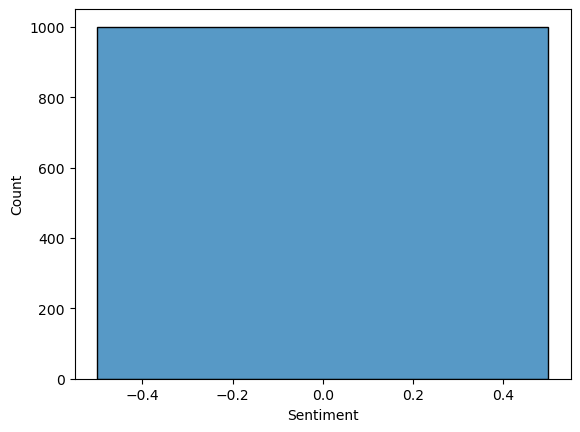

In [152]:
# distribution of negative and positive sentiments
sns.histplot(data=df['Sentiment'], palette='bright')
plt.show()
# much more negative than positive sentiments

# Step 2: Text Preprocessing

In [153]:
import nltk
import contractions
import re

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\linya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\linya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\linya\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [154]:
def tokenize(column):

    # remove '@', 'http', and contractions
    for word in column.split():
      if word.startswith('@'):
        column = column.replace(word, '')
      if word.startswith('http'):
        column = column.replace(word, '')
      if '\'' in word:
        column = column.replace(word, contractions.fix(word))
        # print (word, '->', contractions.fix(word))

    # tokenize, remove punctuation, then stem
    tokens = nltk.word_tokenize(column)
    expanded_tokens = []
    i = 0
    while i < len(tokens):
      # if tokens[i] not in stopwords.words('english'):
      if tokens[i].isalpha():
        expanded_tokens.append(lemmatizer.lemmatize(tokens[i].lower()))
      i += 1

    return expanded_tokens

In [155]:
def join_tokens(column):

    # remove '@', 'http', and contractions
    for word in column.split():
      if word.startswith('@'):
        column = column.replace(word, '')
      if word.startswith('http'):
        column = column.replace(word, '')
      if '\'' in word:
        column = column.replace(word, contractions.fix(word))
        # print (word, '->', contractions.fix(word))

    # tokenize, remove punctuation, then stem
    tokens = nltk.word_tokenize(column)
    expanded_tokens = []
    i = 0
    while i < len(tokens):
      # if tokens[i] not in stopwords.words('english'):
      if tokens[i].isalpha():
        expanded_tokens.append(lemmatizer.lemmatize(tokens[i].lower()))
      i += 1

    return " ".join(expanded_tokens)

In [156]:
df['Tokenized'] = df.apply(lambda x: tokenize(x['Text']), axis=1)
df['Joined Tokens'] = df.apply(lambda x: join_tokens(x['Text']), axis=1)
test_df['Tokenized'] = test_df.apply(lambda x: tokenize(x['Text']), axis=1)
test_df['Joined Tokens'] = test_df.apply(lambda x: join_tokens(x['Text']), axis=1)
df[['Sentiment','Tokenized','Joined Tokens']].head()
# df.head()

,Sentiment,Tokenized,Joined Tokens
0,0,"[awww, that, is, a, bummer, you, shoulda, got,...",awww that is a bummer you shoulda got david ca...
1,0,"[is, upset, that, he, can, not, update, his, f...",is upset that he can not update his facebook b...
2,0,"[i, dived, many, time, for, the, ball, managed...",i dived many time for the ball managed to save...
3,0,"[my, whole, body, feel, itchy, and, like, it, ...",my whole body feel itchy and like it on fire
4,0,"[no, it, is, not, behaving, at, all, i, am, ma...",no it is not behaving at all i am mad why am i...


# Step 3: Linguistic Feature Extraction

In [157]:
# Bag of words model
word2count = {}
for data in df['Joined Tokens']:
    words = nltk.word_tokenize(data)
    for word in words:
        if word not in word2count.keys():
            word2count[word] = 1
        else:
            word2count[word] += 1

unique_words = list(word2count.keys())
bag_of_words = []
for data in df['Joined Tokens']:
    words = nltk.word_tokenize(data)
    bag_vector = np.zeros(len(unique_words))
    for word in words:
        for i, unique_word in enumerate(unique_words):
            if unique_word == word:
                bag_vector[i] += 1
    bag_of_words.append(bag_vector)

# print(bag_of_words)


Text(0.5, 1.0, 'Sparse Matrix Sample')

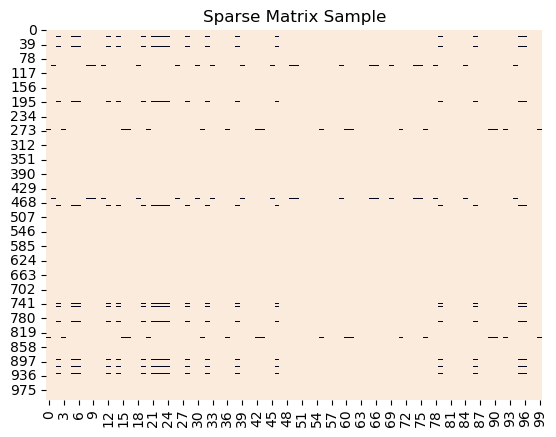

In [158]:
# TF*IDF model
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = []
for data in df['Joined Tokens']:
    corpus.append(data)

# tf_idf_model = TfidfVectorizer()
# tf_idf_vector = tf_idf_model.fit_transform(corpus)

# tf_idf_array = tf_idf_vector.toarray()

vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

sns.heatmap(X_train.todense()[:,np.random.randint(0,df.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

# print(tf_idf_array)

In [159]:
# word2vec/word embedding model
import gensim
from gensim.models import Word2Vec

words = []
test_words = []

for data in df['Tokenized']:
    words.append(data)
for data in test_df['Tokenized']:
    test_words.append(data)

# CBOW model
cbow = gensim.models.Word2Vec(words, min_count = 1,vector_size = 100, window = 5, sg=0)
cbow_test = gensim.models.Word2Vec(test_words, min_count = 1,vector_size = 100, window = 5, sg=0)
# Skip-gram model
skipgram = gensim.models.Word2Vec(words, min_count = 1,vector_size = 100, window = 5, sg=1)
skipgram_test = gensim.models.Word2Vec(test_words, min_count = 1,vector_size = 100, window = 5, sg=1)

# Step 4: Build sentiment classification model

In [160]:
# Naive Bayes classifier model
from sklearn import naive_bayes, pipeline, metrics
classifier = naive_bayes.MultinomialNB()

## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = test_df["Joined Tokens"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

In [166]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    

Accuracy: 0.49
Auc: 0.5
Detail:
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       177
           1       0.00      0.00      0.00       182

    accuracy                           0.49       359
   macro avg       0.25      0.50      0.33       359
weighted avg       0.24      0.49      0.33       359



c:\Users\linya\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\linya\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\linya\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [162]:
# # Logistic Regression
# from sklearn.linear_model import LogisticRegression
# lr = LogisticRegression()

# # with cbow
# train_matrix = cbow.wv.fit_transform(df['Joined Tokens'])
# test_matrix = cbow_test.wv.fit_transform(test_df['Joined Tokens'])

# X_train = train_matrix
# X_test = test_matrix
# y_train = df['Sentiment']
# y_test = test_df['Sentiment']

# lr.fit(X_train, y_train)

# y_pred = lr.predict(X_test)

In [164]:
# # find accuracy, precision:
# from sklearn.metrics import confusion_matrix,classification_report
# new = np.asarray(y_test)
# confusion_matrix(y_pred,y_test)